## Import libraries and data

In [1]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.6 MB/s eta 0:00:00


In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
from scipy import stats
import shap

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression, r_regression
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

In [28]:
data = pd.read_csv("WB_PollinationSimulation_Data.csv")
data.head()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
0,0,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,16.0,0.26,0.410652,0.408159,31.678898,3813.165795
1,1,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,1.0,0.10,0.444254,0.425458,33.449385,4947.605663
2,2,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,16.0,0.26,0.383787,0.399172,30.546306,3866.798965
3,3,37.5,0.75,0.25,0.25,0.25,94.6,57.2,79.0,68.2,33.0,55.9,1.0,0.10,0.407564,0.408789,31.562586,4303.943030
4,4,37.5,0.75,0.25,0.25,0.25,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.354413,0.382703,28.873714,3436.493543


## Statistical data analysis

In [29]:
data.describe()

,Row#,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,388.000000,18.767696,0.417133,0.282389,0.468817,0.562062,82.277091,49.700515,68.723037,59.309395,28.690219,48.613127,18.309292,0.320000,0.502121,0.445983,36.122432,6012.849165
std,224.444871,6.999063,0.978904,0.066343,0.161052,0.169119,9.193745,5.595769,7.676984,6.647760,3.209547,5.417072,12.124226,0.171279,0.079445,0.040333,4.377889,1356.955318
min,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1637.704022
25%,194.000000,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,3.770000,0.100000,0.454725,0.416281,33.116091,5124.854901
50%,388.000000,12.500000,0.250000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.508297,0.445587,36.166044,6107.382466
75%,582.000000,25.000000,0.500000,0.380000,0.630000,0.750000,89.000000,52.000000,71.900000,66.000000,30.000000,50.800000,24.000000,0.390000,0.561297,0.476149,39.239668,7022.189731
max,776.000000,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401842


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 777 entries, 0 to 776
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Row#                  777 non-null    int64  
 1   clonesize             777 non-null    float64
 2   honeybee              777 non-null    float64
 3   bumbles               777 non-null    float64
 4   andrena               777 non-null    float64
 5   osmia                 777 non-null    float64
 6   MaxOfUpperTRange      777 non-null    float64
 7   MinOfUpperTRange      777 non-null    float64
 8   AverageOfUpperTRange  777 non-null    float64
 9   MaxOfLowerTRange      777 non-null    float64
 10  MinOfLowerTRange      777 non-null    float64
 11  AverageOfLowerTRange  777 non-null    float64
 12  RainingDays           777 non-null    float64
 13  AverageRainingDays    777 non-null    float64
 14  fruitset              777 non-null    float64
 15  fruitmass             7

In [31]:
data.columns

Index(['Row#', 'clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

In [32]:
data.dtypes

Row#                      int64
clonesize               float64
honeybee                float64
bumbles                 float64
andrena                 float64
osmia                   float64
MaxOfUpperTRange        float64
MinOfUpperTRange        float64
AverageOfUpperTRange    float64
MaxOfLowerTRange        float64
MinOfLowerTRange        float64
AverageOfLowerTRange    float64
RainingDays             float64
AverageRainingDays      float64
fruitset                float64
fruitmass               float64
seeds                   float64
yield                   float64
dtype: object

In [33]:
data.shape

(777, 18)

In [34]:
data.nunique()

Row#                    777
clonesize                 6
honeybee                  7
bumbles                  10
andrena                  12
osmia                    12
MaxOfUpperTRange          5
MinOfUpperTRange          5
AverageOfUpperTRange      5
MaxOfLowerTRange          5
MinOfLowerTRange          5
AverageOfLowerTRange      5
RainingDays               5
AverageRainingDays        5
fruitset                777
fruitmass               777
seeds                   777
yield                   777
dtype: int64

In [35]:
data.duplicated().sum()

0

<Axes: >

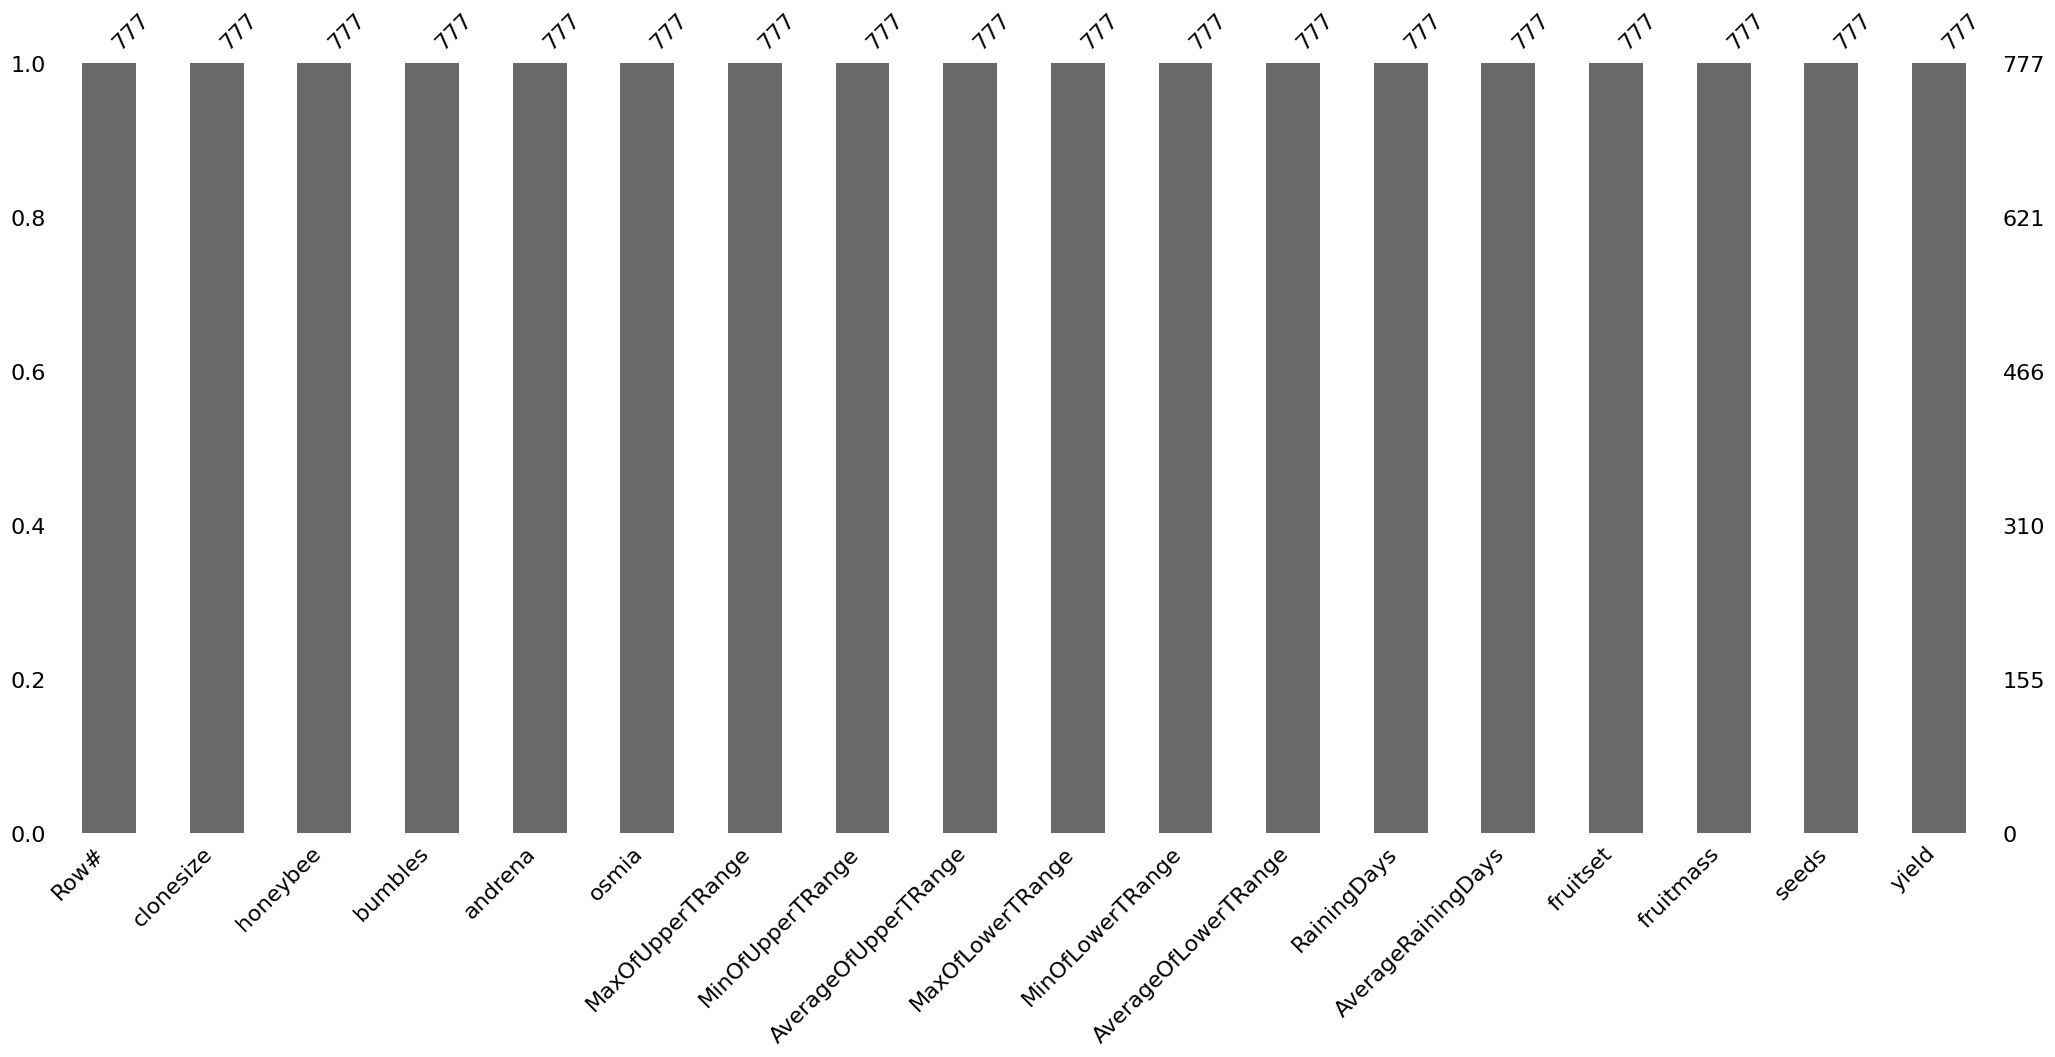

In [36]:
## Checking null values
msno.bar(data)

We don't have any null values. Let's check unique values.

## Visualization

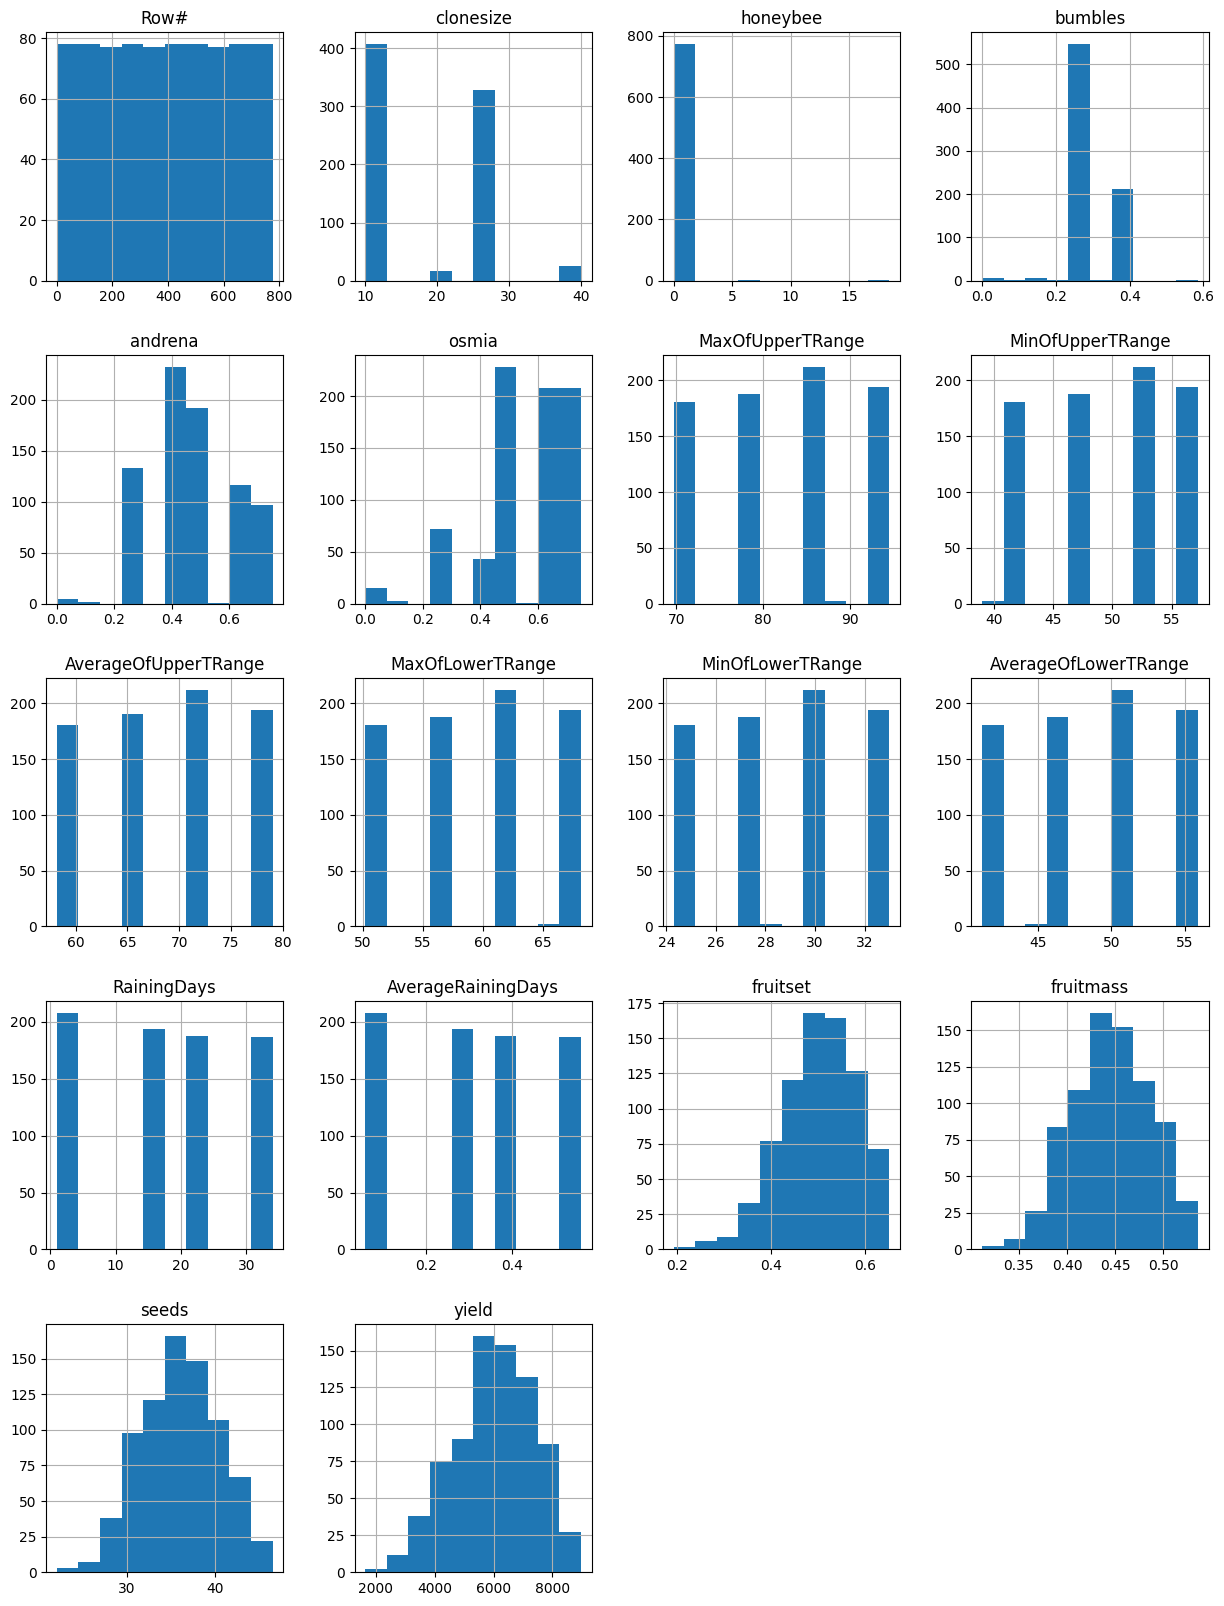

In [37]:
data.hist(figsize=(15,20))
plt.show()

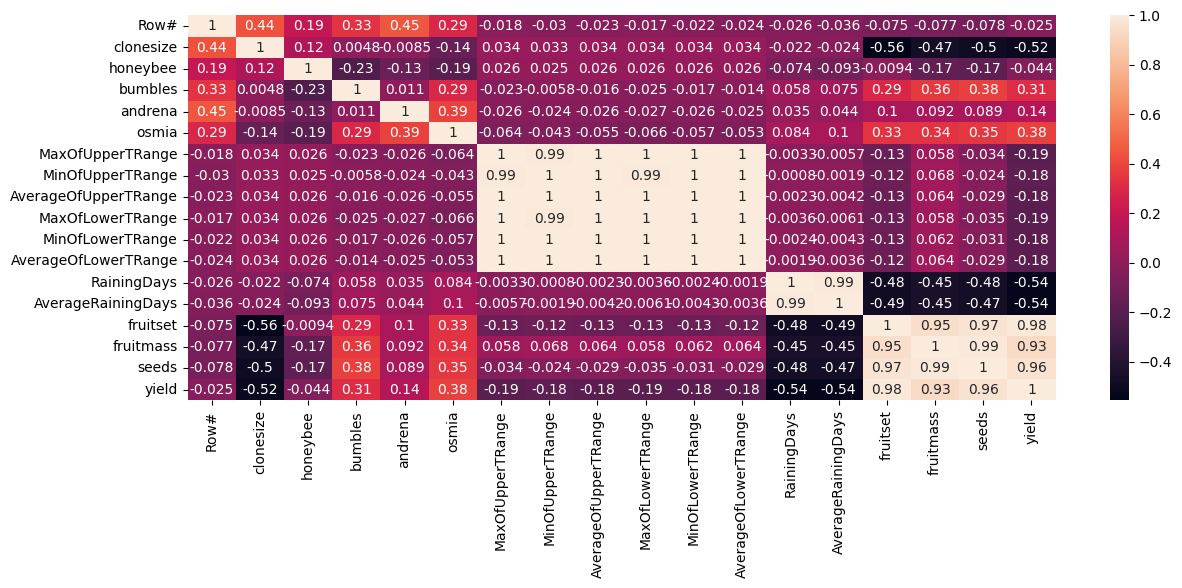

In [38]:
plt.figure(figsize=(14, 5))
sns.heatmap(data.corr(), annot=True)
plt.show()

## Preprocessing


In [39]:
df = data.drop(columns=['Row#', 'MaxOfUpperTRange', 'MinOfUpperTRange', 'MaxOfLowerTRange', 'MinOfLowerTRange', 'RainingDays', 'honeybee', 'fruitset', 'fruitmass', 'seeds'])

Now we will calculate InterQuartile Range (IQR) which is the difference between the third and the first quartile of a distribution (or the 75th percentile minus the 25th percentile). It is a measure of how wide our distribution is since this range contains half of the points of the dataset.

Uses :

* The interquartile range has a breakdown point of 25% due to which it is often preferred over the total range.

* The IQR is used to build box plots, simple graphical representations of a probability distribution.

* The IQR can also be used to identify the outliers in the given data set.

* The IQR gives the central tendency of the data.

Decision Making:

* The data set has a higher value of interquartile range (IQR) has more variability.

* The data set having a lower value of interquartile range (IQR) is preferable.

In [40]:
part1 = df.drop(columns=['yield'])
part2 = df[['yield']]

In [41]:
Q1 = part1.quantile(0.25)
Q3 = part1.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

clonesize               12.50
bumbles                  0.13
andrena                  0.25
osmia                    0.25
AverageOfUpperTRange     7.20
AverageOfLowerTRange     5.00
AverageRainingDays       0.29
dtype: float64


In [42]:
df_iqr = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]
df_iqr.shape

Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`


(759, 8)

Pandas melt() function is used to change the DataFrame format from wide to long. It’s used to create a specific format of the DataFrame object where one or more columns work as identifiers. All the remaining columns are treated as values and unpivoted to the row axis and only two columns - variable and value.

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


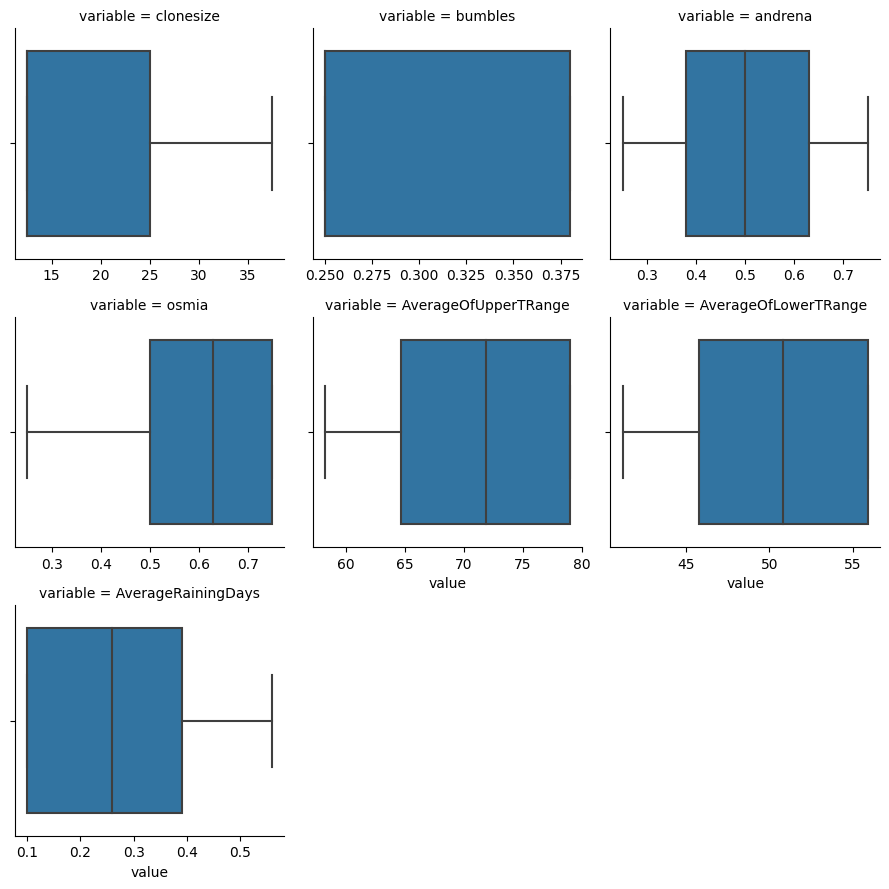

In [43]:
unpivot = pd.melt(df_iqr, df_iqr.describe().columns[-1], df_iqr.describe().columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")

plt.show()

Let's calculate z score now and see how this can change the plots.

Z-score is a statistical measurement that describes a value's relationship to the mean of a group of values. Z-score is measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score.

In [44]:
z = np.abs(stats.zscore(df))
print(z)

     clonesize   bumbles   andrena     osmia  AverageOfUpperTRange  \
0     2.678126  0.488512  1.359549  1.846405              0.414096   
1     2.678126  0.488512  1.359549  1.846405              0.414096   
2     2.678126  0.488512  1.359549  1.846405              1.339534   
3     2.678126  0.488512  1.359549  1.846405              1.339534   
4     2.678126  0.488512  1.359549  1.846405              0.414096   
..         ...       ...       ...       ...                   ...   
772   1.253503  2.494523  0.371655  2.982429              0.414096   
773   3.035546  2.494523  0.371655  2.982429              0.414096   
774   0.176180  2.494523  0.371655  2.982429              0.414096   
775   0.176180  2.494523  0.371655  2.982429              0.407067   
776   0.176180  2.494523  0.371655  2.982429              0.407067   

     AverageOfLowerTRange  AverageRainingDays     yield  
0                0.403960            0.350531  1.622087  
1                0.403960            1.2852

In [45]:
df_zscore = df[(z < 3).all(axis=1)]
df_zscore.shape

(767, 8)

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


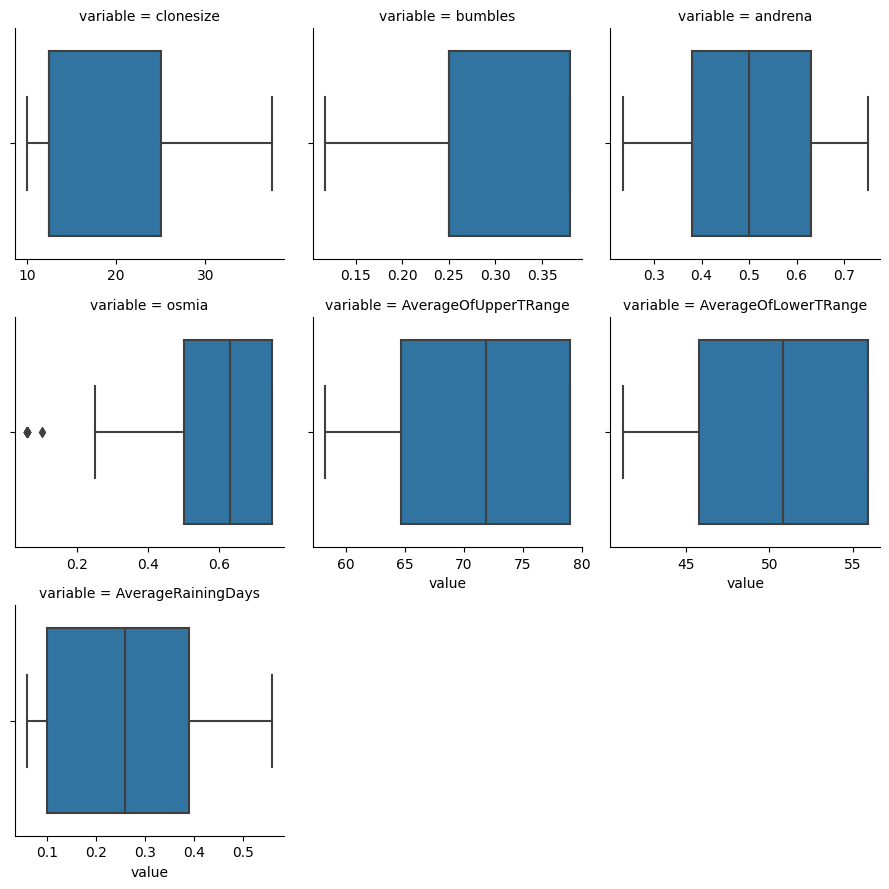

In [46]:
unpivot = pd.melt(df_zscore, df_zscore.columns[-1], df_zscore.columns[:-1])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.boxplot, "value")


plt.show()

In [47]:
df = df_zscore
df

,clonesize,bumbles,andrena,osmia,AverageOfUpperTRange,AverageOfLowerTRange,AverageRainingDays,yield
0,37.5,0.250,0.250,0.250,71.9,50.8,0.26,3813.165795
1,37.5,0.250,0.250,0.250,71.9,50.8,0.10,4947.605663
2,37.5,0.250,0.250,0.250,79.0,55.9,0.26,3866.798965
3,37.5,0.250,0.250,0.250,79.0,55.9,0.10,4303.943030
4,37.5,0.250,0.250,0.250,71.9,50.8,0.39,3436.493543
...,...,...,...,...,...,...,...,...
770,20.0,0.293,0.234,0.058,71.9,50.8,0.06,5449.421199
772,10.0,0.117,0.409,0.058,71.9,50.8,0.06,5333.873335
774,20.0,0.117,0.409,0.058,71.9,50.8,0.39,4203.027624
775,20.0,0.117,0.409,0.058,65.6,45.3,0.06,4166.299735


## Feature Selection

In [48]:
def select_features_corr_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corr = SelectKBest(score_func=f_regression, k='all')
    else:
        fs_corr = SelectKBest(score_func=f_regression, k = x)
    fs_corr.fit(X_train, y_train)
    X_train_fs = fs_corr.transform(X_train)
    X_test_fs = fs_corr.transform(X_test)

    return X_train_fs, X_test_fs, fs_corr

def select_features_infogain_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_info = SelectKBest(score_func=mutual_info_regression, k='all')
    else:
        fs_info = SelectKBest(score_func=mutual_info_regression, k=x)
    fs_info.fit(X_train, y_train)
    X_train_fs = fs_info.transform(X_train)
    X_test_fs = fs_info.transform(X_test)

    return X_train_fs, X_test_fs, fs_info

def select_features_corrcoeff_based(X_train, y_train, X_test, x="all"):
    if type(x) == str:
        fs_corrcoeff = SelectKBest(score_func=r_regression, k='all')
    else:
        fs_corrcoeff = SelectKBest(score_func=r_regression, k=x)
    fs_corrcoeff.fit(X_train, y_train)
    X_train_fs = fs_corrcoeff.transform(X_train)
    X_test_fs = fs_corrcoeff.transform(X_test)

    return X_train_fs, X_test_fs, fs_corrcoeff

In [49]:
X = df.drop(["yield"], axis=1)
y = df['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_fs_corr, X_test_fs_corr, fs_corr = select_features_corr_based(X_train, y_train, X_test)
X_train_fs_info, X_test_fs_info, fs_info = select_features_infogain_based(X_train, y_train, X_test)
X_train_fs_corrcoeff, X_test_fs_corrcoeff, fs_corrcoeff = select_features_corrcoeff_based(X_train, y_train, X_test)

Feature clonesize: 222.199363
Feature bumbles: 53.437111
Feature andrena: 9.952926
Feature osmia: 82.611958
Feature AverageOfUpperTRange: 16.539124
Feature AverageOfLowerTRange: 16.325911
Feature AverageRainingDays: 257.598318


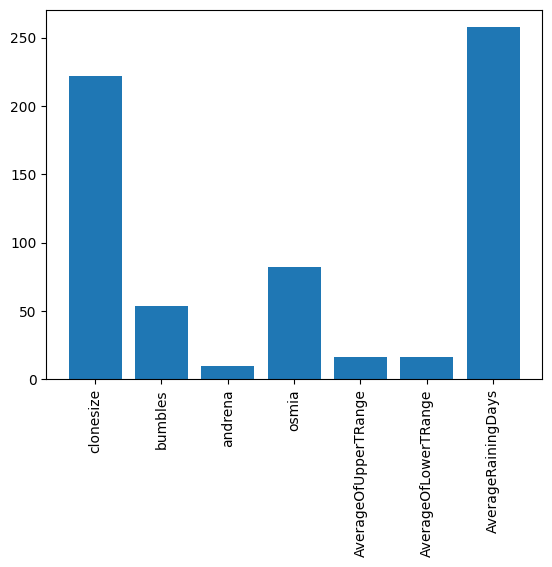

Feature clonesize: 0.188807
Feature bumbles: 0.038575
Feature andrena: 0.048199
Feature osmia: 0.070584
Feature AverageOfUpperTRange: 0.098812
Feature AverageOfLowerTRange: 0.099130
Feature AverageRainingDays: 0.224662


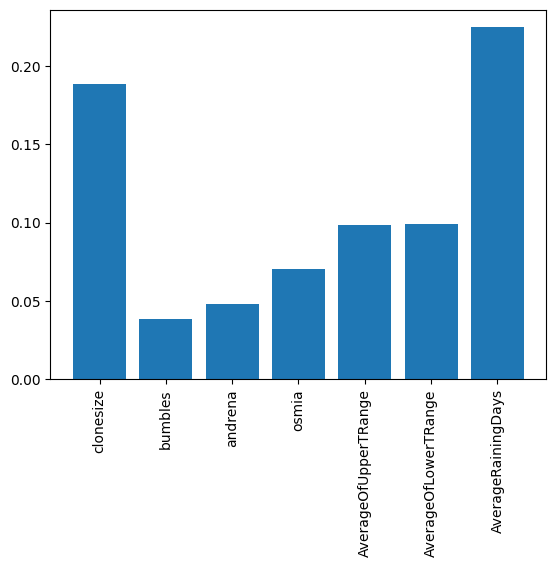

Feature clonesize: -0.542067
Feature bumbles: 0.301607
Feature andrena: 0.135268
Feature osmia: 0.366029
Feature AverageOfUpperTRange: -0.173325
Feature AverageOfLowerTRange: -0.172238
Feature AverageRainingDays: -0.570452


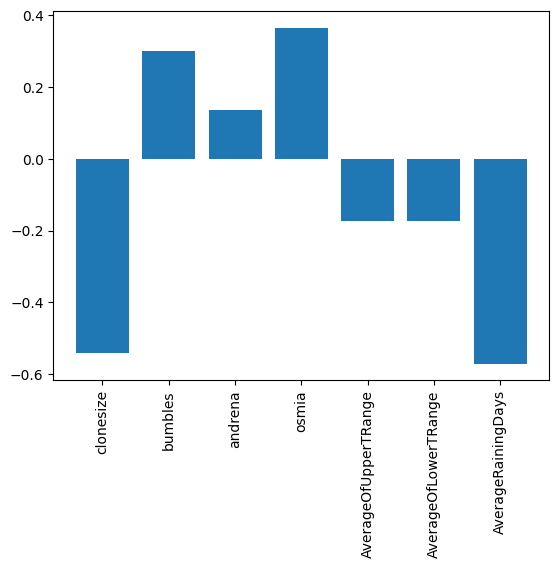

In [51]:
def fs_score_plot(fs_func):

    for i in range(len(fs_func.get_feature_names_out())):
        print('Feature %s: %f' % (fs_func.get_feature_names_out()[i], fs_func.scores_[i]))
    # plot the scores
    plt.bar(fs_func.get_feature_names_out(), fs_func.scores_)
    plt.xticks(rotation=90)
    plt.show()

fs_score_plot(fs_corr)
fs_score_plot(fs_info)
fs_score_plot(fs_corrcoeff)

## Modelling

In [52]:
X = df.drop(["yield"], axis=1)
y = df['yield']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_fs, X_test_fs, fs_info = select_features_infogain_based(X_train, y_train, X_test, x=7)

In [53]:
lreg = LinearRegression()

lreg.fit(X_train_fs, y_train)

yhat = lreg.predict(X_test_fs)

In [54]:
mae_linear = mean_absolute_error(y_test, yhat)
mse_linear = mean_squared_error(y_test, yhat)
rmse_linear = np.sqrt(mse_linear)
rsq_linear = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_linear)
print('MSE: %.3f' % mse_linear)
print('RMSE: %.3f' % rmse_linear)
print('R-Square: %.3f' % rsq_linear)

MAE: 475.802
MSE: 341930.830
RMSE: 584.749
R-Square: 0.811


In [57]:
rf = RandomForestRegressor()

rf.fit(X_train_fs, y_train)

yhat = rf.predict(X_test_fs)

In [58]:
mae_rf = mean_absolute_error(y_test, yhat)
mse_rf = mean_squared_error(y_test, yhat)
rmse_rf = np.sqrt(mse_rf)
rsq_rf = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_rf)
print('MSE: %.3f' % mse_rf)
print('RMSE: %.3f' % rmse_rf)
print('R-Square: %.3f' % rsq_rf)

MAE: 202.206
MSE: 74305.521
RMSE: 272.590
R-Square: 0.959


In [59]:
dtree = DecisionTreeRegressor()

dtree.fit(X_train_fs, y_train)

yhat = dtree.predict(X_test_fs)

In [60]:
mae_dt = mean_absolute_error(y_test, yhat)
mse_dt = mean_squared_error(y_test, yhat)
rmse_dt = np.sqrt(mse_dt)
rsq_dt = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_dt)
print('MSE: %.3f' % mse_dt)
print('RMSE: %.3f' % rmse_dt)
print('R-Square: %.3f' % rsq_dt)

MAE: 242.282
MSE: 99774.659
RMSE: 315.871
R-Square: 0.945


In [62]:
xgb = XGBRegressor()

xgb.fit(X_train_fs, y_train)

yhat = xgb.predict(X_test_fs)

In [63]:
mae_xgb = mean_absolute_error(y_test, yhat)
mse_xgb = mean_squared_error(y_test, yhat)
rmse_xgb = np.sqrt(mse_dt)
rsq_xgb = r2_score(y_test, yhat)

print('MAE: %.3f' % mae_xgb)
print('MSE: %.3f' % mse_xgb)
print('RMSE: %.3f' % rmse_xgb)
print('R-Square: %.3f' % rsq_xgb)

MAE: 178.732
MSE: 55528.967
RMSE: 315.871
R-Square: 0.969
